In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
import string

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
df = pd.read_csv('datasets/billboard.zip')
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
0,6/21/18,NaN,4th Dimension,NaN,Kanye West and Kid Cudi,NaN,42,0,1,42,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
3,6/21/18,NaN,Alone,NaN,Halsey Featuring Big Sean & Stefflon Don,NaN,70,73,9,74,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
4,6/21/18,NaN,Babe,NaN,Sugarland Featuring Taylor Swift,NaN,72,0,2,95,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.


In [49]:
df.shape

(7573, 31)

In [50]:
df = df[df['lyrics'].str.contains("Error: Could not find lyrics.") == False]

In [51]:
df.shape

(7228, 31)

In [52]:
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,NaN,Back To You,NaN,Selena Gomez,NaN,22,31,5,22,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,NaN,Be Careful,NaN,Cardi B,NaN,11,25,11,23,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,NaN,Beautiful Crazy,NaN,Luke Combs,NaN,58,77,4,93,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [53]:
cols = ['simple_title', 'main_artist', 'year', 'peak_pos', 'last_pos', 'weeks', 'rank', 'change', 'video_link', 'broad_genre']

In [54]:
df = df.drop(cols, axis=1)

In [55]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,[u'rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"[u'pop rap', u'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"[u'dance pop', u'pop', u'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"[u'pop', u'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"[u'contemporary country', u'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


genre_preprocess removes the unnecessary "u" from each list of genres.

In [56]:
def genre_preprocess(text : str) -> str:
    text = re.sub("u'", "'", text)
    return text

df['genre'] = df.genre.apply(genre_preprocess)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [57]:
df.shape

(7228, 21)

In [58]:
def clean_lyrics(text):
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode()
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub('\s{2,}', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(' s ', ' ', text)
    text = re.sub(' m ', ' ', text)
    return text

In [59]:
df['clean_lyrics'] = df.lyrics.apply(clean_lyrics)

In [60]:
text = " ".join(i for i in df.clean_lyrics)

In [61]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [62]:
df = df.reset_index(drop=True)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
0,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
1,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
2,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
3,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
4,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


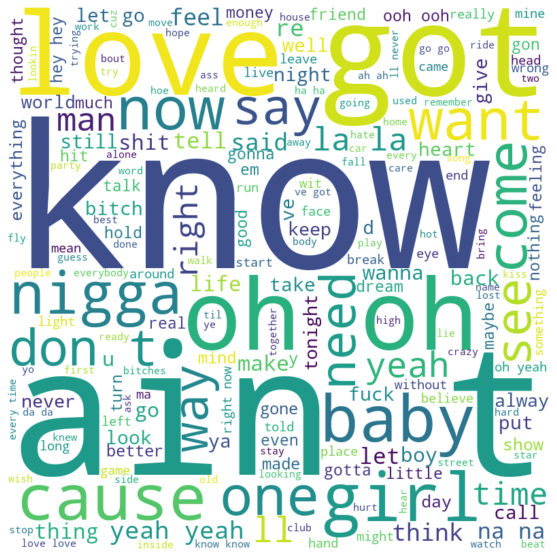

In [63]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TF-IDF Vectorizer. Here I'm creating a TF-IDF matrix based on the "clean_lyrics" column that was created earlier.

In [64]:
tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(df['clean_lyrics'])
lyrics_df = pd.DataFrame(tf_idf_matrix.toarray())
tf_idf.get_feature_names_out()
print(tf_idf_matrix.shape)

(7228, 36031)


In [65]:
print(tf_idf_matrix[0])

  (0, 5063)	0.04164588759044206
  (0, 21849)	0.22009339257867983
  (0, 23105)	0.11106370014442714
  (0, 8250)	0.1425524041114188
  (0, 21668)	0.04486374112348801
  (0, 5120)	0.08029966818522792
  (0, 11377)	0.05604681483483719
  (0, 9714)	0.07331877458084865
  (0, 13068)	0.06358016709590804
  (0, 32159)	0.04443120535826458
  (0, 34642)	0.08248225499362892
  (0, 32847)	0.05828213778469774
  (0, 17375)	0.016640894168490378
  (0, 19996)	0.0318999588034285
  (0, 18548)	0.07037229474525808
  (0, 28684)	0.09504976461997447
  (0, 30238)	0.08940678984199327
  (0, 3648)	0.07762839782070076
  (0, 13074)	0.06064042078524505
  (0, 9504)	0.06559121034811839
  (0, 18278)	0.1015245933228761
  (0, 3874)	0.03850329304958919
  (0, 32269)	0.02831256807146877
  (0, 31287)	0.04703009103796134
  (0, 35410)	0.032156460273450975
  :	:
  (0, 14141)	0.06795598797746259
  (0, 3682)	0.05345473605845148
  (0, 34985)	0.039717402601274654
  (0, 18779)	0.12303706866988146
  (0, 28700)	0.05736670457637543
  (0, 12446)

In [66]:
cos_sim = cosine_similarity(tf_idf_matrix)

This function returns the index numbers of the song that is being entered into the recommendation system. This is the song the user wants to find more of.

In [67]:
def get_index(df, artist_name : str, song_name : str) -> int:
    row_num = df[(df['artist'] == artist_name) & (df['title'] == song_name)].index[0]
    return row_num



This just test's the code to see if it works.

In [68]:
row_num = get_index(df=df, artist_name='Juice WRLD', song_name='All Girls Are The Same')
print(row_num)

0


This code returns the cosine similarity scores of all the songs. I've set it up so that it returns the most similar scores in descending order. That being the most similar are at the top and the least similar are at the bottom.

In [69]:
score_series = pd.Series(cos_sim[row_num]).sort_values(ascending=False)

Returns the top five songs that are most similar to the song chosen.

In [70]:
top_5_indexes = list(score_series.iloc[1:6].index)

In [71]:
recommended_songs = []
for i in top_5_indexes:
    recommended_songs.append(list(df.index)[i])
print(recommended_songs)

[1726, 3988, 2125, 4180, 2232]


In [72]:
def get_song_details(df, songs : list) -> list:
    song_rows = df.iloc[songs]
    return song_rows

get_song_details(df, songs=recommended_songs)


,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
1726,1/31/15,No Love,august alsina,https://embed.spotify.com/?uri=spotify:track:7...,7ewfvLrlI0VNht4vEnoTMh,"['dance pop', 'deep pop r&b', 'hip pop', 'indi...",https://api.spotify.com/v1/audio-analysis/7ewf...,0.625,0.863,130.794,...,0,4,0.593,0,276080,-7.957,0.322,0,August (she said she understands yeah)\nYoung ...,august she said understands yeah young money i...
3988,9/26/09,She Is Love,parachute,https://embed.spotify.com/?uri=spotify:track:2...,2Dz5WpEWA0vhnMmEPYiZ2y,"['acoustic pop', 'indiecoustica', 'neo mellow'...",https://api.spotify.com/v1/audio-analysis/2Dz5...,0.175,0.109,136.365,...,0,1,0.622,6,146067,-9.866,0.376,1,"I've been beaten down, I've been kicked around...",i ve beaten down i ve kicked around but takes ...
2125,1/1/14,Who You Love,john mayer,https://embed.spotify.com/?uri=spotify:track:7...,7IByJvSqRFltGyiiIiL4wn,"['neo mellow', 'pop', 'pop rock', 'singer-song...",https://api.spotify.com/v1/audio-analysis/7IBy...,0.351,0.097,145.907,...,0.00165,4,0.694,9,249933,-10.92,0.691,1,"You love, who you love, Who you love\nYou love...",love love love you love love love my girl ain ...
4180,4/25/09,My Love,the-dream,https://embed.spotify.com/?uri=spotify:track:4...,4ZXvpc8EJwsEUOZnbcFNPQ,"['dance pop', 'deep pop r&b', 'dirty south rap...",https://api.spotify.com/v1/audio-analysis/4ZXv...,0.632,0.152,82.468,...,0,4,0.361,0,204613,-4.8,0.314,1,Radio Killa\ndid a song with the American Drea...,radio killa did song american dream they can t...
2232,10/5/13,The Way,ariana grande,https://embed.spotify.com/?uri=spotify:track:0...,06EL94D0TA27Ik0Ke5usbj,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/06EL...,0.879,0.0742,82.518,...,0,4,0.644,5,227027,-3.179,0.83,0,"What we gotta do right here is go back, back i...",gotta right go back back town i love way make ...


This function returns the song title and the name of the artist that is being recommended based on the song chosen.

In [116]:
def get_song_artist_titles(df, songs : list) -> list:
    song_rows = df.iloc[songs]
    print("Serving up your top five song recommendations!")
    print("-"*50)
    print("   Title\tArtist")
    for i in range(len(song_rows)):
        print(f"{i+1}. {song_rows.title[songs[i]]}\t{song_rows.artist[songs[i]]}")

get_song_artist_titles(df=df, songs=recommended_songs)

Serving up your top five song recommendations!
--------------------------------------------------
   Title	Artist
1. No Love	august alsina
2. She Is Love	parachute
3. Who You Love	john mayer
4. My Love	the-dream
5. The Way	ariana grande
